In [1]:
%matplotlib inline

import sys
import os

root_path = os.path.dirname(os.getcwd())
if root_path not in sys.path:
    sys.path.append(root_path)
    

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from lirGAN.model import LirDataset, LirGenerator, LirDiscriminator, LirGeometricLoss, LirGanTrainer
from lirGAN.data import utils
from lirGAN.config import ModelConfig


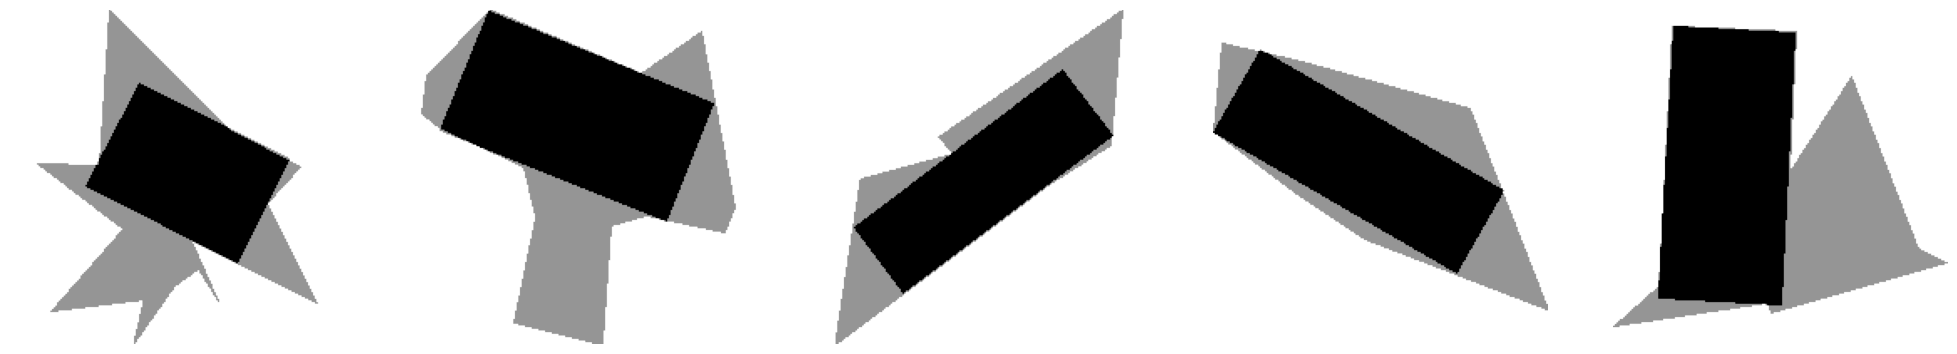

In [2]:
"""visualizing boundary polygons and target rectangles
"""

slicer = 5
lir_dataset_to_visualize = LirDataset(slicer=slicer)

binary_grids = []
for i in range(slicer):
    input_polygon, target_ilr = lir_dataset_to_visualize[i]
    merged_grid = (input_polygon.squeeze() + target_ilr.squeeze()).detach().cpu().numpy()
    
    binary_grids.append(merged_grid)

utils.visualize_binary_grids(binary_grids)

In [2]:
"""Test base models using only one data"""

lir_dataset = LirDataset(slicer=1)
lir_dataloader = DataLoader(
    dataset=lir_dataset,
    batch_size=ModelConfig.BATCH_SIZE,
    shuffle=True,
)

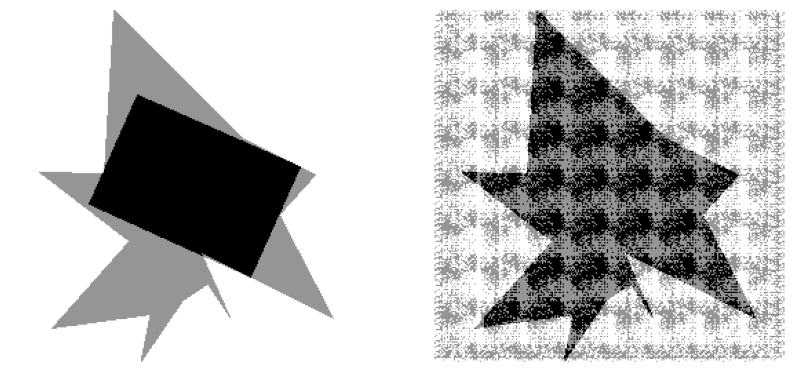

In [3]:
"""Test to train models with no Geometric loss function & no Tanh during 1000 epochs"""

lir_generator = LirGenerator(use_tanh=False)
lir_discriminator = LirDiscriminator()

lir_gan_trainer = LirGanTrainer(
    lir_generator=lir_generator,
    lir_discriminator=lir_discriminator,
    lir_dataloader=lir_dataloader,
    initial_weights_key=ModelConfig.XAVIER,
    use_gradient_penalty=True,
)

lir_gan_trainer.train()

In [ ]:
"""Test to train models with no Geometric loss function & Tanh"""

lir_generator = LirGenerator(use_tanh=True)
lir_discriminator = LirDiscriminator()

lir_gan_trainer = LirGanTrainer(
    lir_generator=lir_generator,
    lir_discriminator=lir_discriminator,
    lir_dataloader=lir_dataloader,
    initial_weights_key=ModelConfig.XAVIER,
    use_gradient_penalty=True,
)

lir_gan_trainer.train()

In [ ]:
"""Test to train models with Geometric loss function & no Tanh"""

lir_generator = LirGenerator(use_tanh=False)
lir_discriminator = LirDiscriminator()
lir_geometric_loss_function = LirGeometricLoss(bce_weight=1.0, diou_weight=2.0, feasibility_weight=5.0)

lir_gan_trainer = LirGanTrainer(
    lir_generator=lir_generator,
    lir_discriminator=lir_discriminator,
    lir_dataloader=lir_dataloader,
    lir_geometric_loss_function=lir_geometric_loss_function,
    initial_weights_key=ModelConfig.XAVIER,
    use_gradient_penalty=True,
)

lir_gan_trainer.train()

In [ ]:
"""Test to train models with Geometric loss function & Tanh"""

lir_generator = LirGenerator(use_tanh=False)
lir_discriminator = LirDiscriminator()
lir_geometric_loss_function = LirGeometricLoss(bce_weight=1.0, diou_weight=2.0, feasibility_weight=5.0)

lir_gan_trainer = LirGanTrainer(
    lir_generator=lir_generator,
    lir_discriminator=lir_discriminator,
    lir_dataloader=lir_dataloader,
    lir_geometric_loss_function=lir_geometric_loss_function,
    initial_weights_key=ModelConfig.XAVIER,
    use_gradient_penalty=True,
)

lir_gan_trainer.train()